# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import random
import time
import utils

# modify to where you store your project data including utils.py
# datadir = "/content/drive/My Drive/cs445_projects/proj2/" 

# utilfn = datadir + "utils.py"
# !cp "$utilfn" .
# samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .
# import utils

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order 
    to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    output = np.zeros((out_size,out_size,3), dtype=np.float32)
    number = out_size // patch_size
    r_max = sample.shape[0] - patch_size
#     print(sample.shape[0])
    r_min = 0
#     print(r_max, r_min)
#     print(rand)
#     print("numbter is,", number) #num is 5
    for i in range(number):
        for j in range(number):
            rand_start = (int)(random.randrange(r_min,r_max))
            new_x1 = rand_start
            new_x2 = rand_start + patch_size
            new_y1 = new_x1
            new_y2 = new_x2
            test_block = np.array(sample[new_y1:new_y2, new_x1:new_x2])#get a random block here
#             print(test_block.shape) 
            #put the test_block in to its position
            x1 = j *patch_size
            y1 = i *patch_size
            x2= x1 + patch_size
            y2= y1 + patch_size
            #notice, confused about xy position. Check it later
            output[y1:y2, x1:x2] = test_block
#             print("x1, y1", x1, y1)
#             print("x2, y2", x2, y2)
    return output


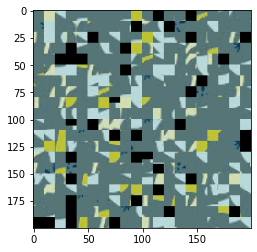

In [29]:
sample_img_fn = 'samples/maxresdefault.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
# plt.imshow(sample_img) #(192, 192, 3)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 10 
res = quilt_random(sample_img, out_size, patch_size)

#the dtype is wrong. fix it by changing the dtype to int32(originally float32)
#https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
res = np.array(res, np.int32)
plt.imshow(res)
plt.show()
# if res is not None:
#     plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [5]:
def getOnePatch(sample_img, patch_size):
    r_max = sample_img.shape[0] - patch_size
    r_min = 0
    rand_start = (int)(random.randrange(r_min,r_max))
    new_x1 = rand_start
    new_x2 = rand_start + patch_size
    new_y1 = new_x1
    new_y2 = new_x2
    rand_patch = np.array(sample_img[new_y1:new_y2, new_x1:new_x2])
    return rand_patch
    

In [6]:
#fix this section
# ssd_cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) \
# + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

#  Each pixel of the ssd_cost gives you the cost for sampling a patch centered around that pixel.
#input sample picture, 

# ssd_patch performs template matching with the overlapping region, computing the cost
# of sampling each patch, based on the sum of squared differences (SSD) of the overlapping
# regions of the existing and sampled patch

def ssd_patch(I, T, M, patch_size):
#     I = np.array(I, np.float32)
# I, T, M, should all be in float32.
#     print(I.dtype, T.dtype, M.dtype)
    ssd_cost_raw = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    sample_size = I.shape[0]
    ssd_cost_result = np.zeros((sample_size,sample_size), dtype=np.float32) 
    start_index = (patch_size) // 2

    end_index = sample_size - start_index
    for i in range(start_index, end_index + 1):
        for j in range(start_index, end_index + 1):
#             print(ssd_cost_raw[i, j])
            ssd_cost_result[i,j] = ssd_cost_raw[i, j].sum()
#             print(ssd_cost_raw[i, j].sum())
#             print(ssd_cost_raw.dtype)

    
#     print("start_index, end_index", start_index, end_index)
#     return ssd_cost_raw
#     print(ssd_cost_result.dtype)
    return ssd_cost_result
#ssd_cost_result contains a matrix, size of sample, one channel. each pixel represents the 
#sum of surronding ssd. THE FIRST AND LAST ROW && COL IS 0, SIZE OF PATCH_SIZE//2

#9/24 dont know if it is ok

In [7]:
import heapq

# choose_sample should take as input a cost image 
# (each pixel's value is the cost of selecting the patch centered
#  at that pixel) and select a randomly sampled patch with low cost.
# It's recommended to sort the costs and choose of of the tol smallest costs. 
# So if tol=1, the lowest cost will always be chosen (this is a good way to debug 
# but mainly copies the input texture). If tol=3, one of the three lowest cost patches 
# will be chosen.
def choose_sample(sample, patch_size, cost_image, tol):
    #input: 
    #output: choose one KEY from list of 'tol' number of smallest (key, value) pair
    #value is (i,j), center of balabala
    min_cost = float("inf")
    store_tol_pairs = []
    result_list = []
#     cost_image.flatten()
#     print(cost_image.shape)
    
    start_index = patch_size // 2
    sample_size = sample.shape[0]
    end_index = sample_size - start_index
            
#     print(start_index,end_index )    
    #maintain a PQ, from small val to large val. Then pop the largest 'tol' numbers of value
    #key is the cost_value, and value is [i, j] position
    #will occupy a huge memory. probably 
    for i in range (start_index,end_index+1):
        for j in range (start_index,end_index+1):
            heapq.heappush(store_tol_pairs, (cost_image[i,j], (i,j)))
#             if cost_image[i,j] < min_cost and cost_image[i,j] != 0:
#                 min_cost = cost_image[i,j]

    for x in range (tol):
        result_list.append(heapq.heappop(store_tol_pairs))

    pick_random_number = (int)(random.randrange(0,tol))
    
    return result_list[pick_random_number][1]#randomly return one position
    
    
    


In [28]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: int
    :return: numpy.ndarray
    """
    
    sample = np.array(sample, np.float32)#cast from unit8 to float32
    output = np.zeros((out_size,out_size,3), dtype=np.float32)

    
    loop_number = (out_size - patch_size) // (patch_size - overlap) + 1
    #need to loop this much on cols and rows
    #you can move len(patch_size - overlap) each time
    
    
#     mask[:,0:overlap] = 1.0 #左边一条
#     mask[0:overlap,:] = 1.0 #上边一条


# ###     ssd_patch(I, T, M, patch_size)
    for i in range(loop_number): #i related to y
        for j in range(loop_number): #j related to x
            print("running")
            mask = np.zeros((patch_size,patch_size,3), dtype=np.float32)
            if(i == 0 and j == 0): #top left, randomly assign a patch
#                 print("top left")
                first_patch = getOnePatch(sample_img, patch_size)
                first_patch = np.array(first_patch, np.float32)
                output[0:patch_size,0:patch_size] = first_patch
# output[0:patch_size,0:patch_size] = sample[a:a+patch_size,b:b+patch_size]
#                 show_first_patch = np.array(first_patch, np.int32)
#                 show_output = np.array(output, np.int32)
#                 plt.imshow(show_output)
#                 plt.show()
            elif(i == 0):#first row, | shape mask
#                 print("first row", (i, j))
                mask[:,0:overlap] = 1.0 
            elif(j == 0): #first col, - shape mask
#                 print("first col", (i, j))
                mask[0:overlap,:] = 1.0
            else:
                mask[0:overlap,:] = 1.0
                mask[:,0:overlap] = 1.0 
#                 print("other")
                
            #make template
            each_hop = patch_size - overlap
            current_y = each_hop * i
            current_x = each_hop * j
#             print("current_x,current_y", (current_x,current_y))
            template = output[current_y:current_y + patch_size, current_x:current_x+patch_size]

     ########apply mask, template, image to SSD########
#             ssd_patch(I, T, M, patch_size)
            cost_SSD = ssd_patch(sample, template, mask, patch_size)
            
    ########get the random position########
#             choose_sample(sample, patch_size, cost_image, tol)
            chosen_position = choose_sample(sample, patch_size, cost_SSD, tol)
#             print("chosen_position", chosen_position)
    
     ########put it in the OUTPUT picture########
            chosen_y = chosen_position[0]
            chosen_x = chosen_position[1]
            half_ps = patch_size // 2
#             print(half_ps)
            output[current_y:current_y + patch_size, current_x:current_x + patch_size] = \
            sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]


#             output[current_y:current_y + patch_size, current_x:current_x + patch_size] = \
#             sample[chosen_x-half_ps : chosen_x+half_ps, chosen_y-half_ps : chosen_y+half_ps]
    
#             output[current_x:current_x + patch_size, current_y:current_y + patch_size] = \
#             sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]    
    
#             print(chosen_x-half_ps, chosen_x+half_ps)
#             print(current_x,current_x + patch_size)
    return output


(600, 600, 3)


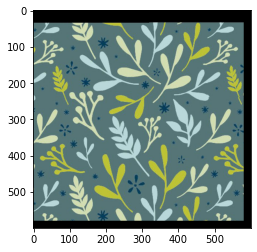

In [27]:
sample_img_fn = 'samples/maxresdefault.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
# plt.imshow(sample_img)
# plt.show()
overlap = 20
tol = 3
out_size = 600  # change these parameters as needed
patch_size = 100 
# print(sample_img.shape)(192, 192, 3)

# rand_block = getOnePatch(sample_img, patch_size)

# 三维矩阵y[i,j,m]的参数理解：
# 第一维 i：确定是哪一个二维矩阵
# 第二维 j：每一个二维矩阵的行
# 第三维 m：每一个二维矩阵的列
# test = np.array([[[1,1,1]], [[1,1,1]]])#(2, 1, 3)
# print(test[1][0].sum()) #3

res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
res_pic = np.array(res, np.int32)
print(res_pic.shape)
plt.imshow(res_pic)

# plt.savefig('./output_res/p2_brick2.jpg')
plt.show()
# if res is not None:
#     plt.figure(figsize=(10,10))
#     plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [10]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [11]:
def calculate_ssd(previous, current, patch_size, overlap, overlap_type ):
#To find a vertical path, you can apply cut to the transposed patch, e.g., cut(bndcost.T).T.
    """
    previous: previous patchnew_one
    current: the new patch added to the graph

    return: the ssd of two patches
    """
    res_x = previous.shape[1]
    res_y = previous.shape[0]
    if (overlap_type == "rows"):
        right_of_p = previous[0:patch_size, patch_size-overlap:patch_size]
        left_of_c = current[0:patch_size, 0:overlap]
        result_diff = np.zeros((patch_size,overlap),dtype=np.float32)
        err_diff = np.square(right_of_p - left_of_c)
        for i in range(patch_size):
            for j in range(overlap):
                result_diff[i,j] = err_diff[i][j].sum()
            
        
    elif(overlap_type == "cols"):
#         print("in the function, cols")
        bottom_of_p = previous[patch_size-overlap:patch_size, 0:patch_size]
        top_of_c = current[0:overlap, 0:patch_size]
        result_diff = np.zeros((overlap,patch_size),dtype=np.float32)
        err_diff = np.square(bottom_of_p - top_of_c)
        for i in range(overlap):
            for j in range(patch_size):
                result_diff[i,j] = err_diff[i][j].sum()
        result_diff = result_diff.T
    
    
    return result_diff

    


    
    

In [23]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    sample = np.array(sample, np.float32)#cast from unit8 to float32
    output = np.zeros((out_size,out_size,3), dtype=np.float32)
    loop_number = (out_size - patch_size) // (patch_size - overlap) + 1
    
#     mask[:,0:overlap] = 1.0 #左边一条
#     mask[0:overlap,:] = 1.0 #上边一条

    for i in range(loop_number): #i related to y
        for j in range(loop_number): #j related to x
            mask = np.zeros((patch_size,patch_size,3), dtype=np.float32)

            if(i == 0 and j == 0): #top left, randomly assign a patch
                first_patch = getOnePatch(sample_img, patch_size)
                first_patch = np.array(first_patch, np.float32)
                output[0:patch_size,0:patch_size] = first_patch
                continue
            elif(i == 0):#first row, | shape mask
                mask[:,0:overlap] = 1.0 
            elif(j == 0): #first col, - shape mask
                mask[0:overlap,:] = 1.0
            else:
                mask[0:overlap,:] = 1.0
                mask[:,0:overlap] = 1.0 
            each_hop = patch_size - overlap
            current_y = each_hop * i
            current_x = each_hop * j
            template = output[current_y:current_y + patch_size, current_x:current_x + patch_size]
     ########apply mask, template, image to SSD########
            cost_SSD = ssd_patch(sample, template, mask, patch_size)           
    ########get the random position########
            chosen_position = choose_sample(sample, patch_size, cost_SSD, tol)
     ########put it in the OUTPUT picture########
            chosen_x = chosen_position[1]
            chosen_y = chosen_position[0]
            half_ps = patch_size // 2
            
            ##################################   
    ##########deal with overlap cost########## 
    ################################## 
            if  i == 0 and j  == 0:
                continue
            elif i == 0:
                old_y = each_hop * i
                old_x = each_hop * (j -1)
                chosen_new_patch = sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]
                old_patch = output[old_y:old_y + patch_size, old_x:old_x + patch_size]
                right_of_p = old_patch[0:patch_size, patch_size-overlap:patch_size]
                left_of_c = chosen_new_patch[0:patch_size, 0:overlap]
                patch_ssd = calculate_ssd(old_patch, chosen_new_patch, patch_size, overlap,"rows")
                

                use_cut_result = cut(patch_ssd.T).T
                

                left_mask = np.zeros((patch_size, overlap, 3), dtype = np.float32)                     
                for a in range(patch_size):
                    for b in range(overlap):
                        if (use_cut_result[a][b] == 0):
                            for c in range (3):
                                left_mask[a][b][c] = 1.0        
                left_right_mix = right_of_p*left_mask + left_of_c*(1 - left_mask)
                
                output[current_y:current_y + patch_size, current_x:current_x + patch_size] = \
                sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]
                ##overlap for right_left
                output[current_y:current_y + patch_size,current_x:current_x + overlap] = left_right_mix
            elif j == 0:
                old_y = each_hop * (i-1)
                old_x = each_hop * j
                chosen_new_patch = sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]
                old_patch = output[old_y:old_y + patch_size, old_x:old_x + patch_size]
                bottom_of_p = old_patch[patch_size - overlap:patch_size, 0:patch_size]
                top_of_c = chosen_new_patch[0:overlap, 0:patch_size]
      
                patch_ssd2 = calculate_ssd(old_patch, chosen_new_patch, patch_size, overlap,"cols")
                use_cut_result = cut(patch_ssd.T)#should be a "-" shape matrix
#                 print("patch_ssd," patch_ssd.shape)
#                 print("in col")

                top_mask = np.zeros((overlap, patch_size, 3), dtype = np.float32)
                            
                for a in range(overlap):
                    for b in range(patch_size):
                        if (use_cut_result[a][b] == 0):
                            for c in range (3):
                                top_mask[a][b][c] = 1.0
# #                 print("left_mask,", left_mask.shape)
# #                 right_mask = np.zeros((patch_size, patch_size, 3), dtype = np.float32)           
                bottom_top_mix = bottom_of_p*top_mask + top_of_c*(1 - top_mask)
                
        
                output[current_y:current_y + patch_size, current_x:current_x + patch_size] = \
                sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]
                
                ##overlap for bottom_top
                output[current_y:current_y + overlap,current_x:current_x + patch_size] = bottom_top_mix
                       
            else:
                print("running")
                ############
                ############
                #left right old patch
                old_y = each_hop * i
                old_x = each_hop * (j -1)
                chosen_new_patch = sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]
                old_patch_l_r = output[old_y:old_y + patch_size, old_x:old_x + patch_size]
                right_of_p = old_patch_l_r[0:patch_size, patch_size-overlap:patch_size]
                left_of_c = chosen_new_patch[0:patch_size, 0:overlap]
                patch_ssd_left_right = calculate_ssd(old_patch_l_r, chosen_new_patch, patch_size, overlap,"rows")
                use_cut_result = cut(patch_ssd_left_right.T).T
                left_mask = np.zeros((patch_size, overlap, 3), dtype = np.float32)
                for a in range(patch_size):
                    for b in range(overlap):
                        if (use_cut_result[a][b] == 0):
                            for c in range (3):
                                left_mask[a][b][c] = 1.0              
                left_right_mix = right_of_p*left_mask + left_of_c*(1 - left_mask)
                output[current_y:current_y + patch_size, current_x:current_x + patch_size] = \
                sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]
                
                output[current_y:current_y + patch_size,current_x:current_x + overlap] = left_right_mix
                ########################
                ########################
                #bottom top old patch
                old_y_2 = each_hop * (i-1)
                old_x_2 = each_hop * j
                
                old_patch_t_b = output[old_y_2:old_y_2 + patch_size, old_x_2:old_x_2 + patch_size]
                bottom_of_p = old_patch_t_b[patch_size - overlap:patch_size, 0:patch_size]
                top_of_c = chosen_new_patch[0:overlap, 0:patch_size]     
                patch_ssd_bottom_top = calculate_ssd(old_patch_t_b, chosen_new_patch, patch_size, overlap,"cols")
                use_cut_result_2 = cut(patch_ssd_bottom_top.T)#should be a "-" shape matrix
# #                 print("patch_ssd," patch_ssd.shape)
# #                 print("in col")

                top_mask = np.zeros((overlap, patch_size, 3), dtype = np.float32)
                            
                for a in range(overlap):
                    for b in range(patch_size):
                        if (use_cut_result_2[a][b] == 0):
                            for c in range (3):
                                top_mask[a][b][c] = 1.0
# # #                 print("left_mask,", left_mask.shape)
# # #                 right_mask = np.zeros((patch_size, patch_size, 3), dtype = np.float32)           
                bottom_top_mix = bottom_of_p*top_mask + top_of_c*(1 - top_mask)
#                 output[current_y:current_y + patch_size, current_x:current_x + patch_size] = \
#                 sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]
                
                output[current_y:current_y + overlap,current_x:current_x + patch_size] = bottom_top_mix
             
                
            
            
#             output[current_y:current_y + patch_size, current_x:current_x + patch_size] = \
#             sample[chosen_y-half_ps : chosen_y+half_ps, chosen_x-half_ps : chosen_x+half_ps]

    
                
# 三维矩阵y[i,j,m]的参数理解：
# 第一维 i：确定是哪一个二维矩阵
# 第二维 j：每一个二维矩阵的行
# 第三维 m：每一个二维矩阵的列
                
                
    return output



running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running


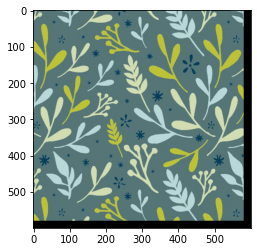

In [25]:
sample_img_fn = 'samples/maxresdefault.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
# plt.imshow(sample_img)
# plt.show()

out_size = 600  # change these parameters as needed
patch_size = 100
overlap = 20
tol = 3

res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
show_output = np.array(res, np.int32)
plt.imshow(show_output)
# plt.savefig('./output_res/p3_bricks.jpg')
plt.show()

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    

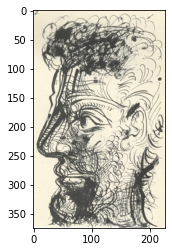

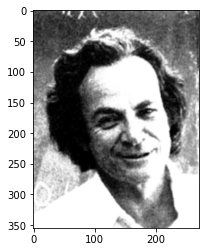

In [15]:
# load/process appropriate input texture and guidance images
sample_img_fn = 'samples/sketch.tiff' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
target_img_fn = 'samples/feynman.tiff' 
target_img = cv2.cvtColor(cv2.imread(target_img_fn), cv2.COLOR_BGR2RGB)

plt.imshow(sample_img)
# plt.savefig('./output_res/p3_bricks.jpg')
plt.show()
plt.imshow(target_img)
plt.show()

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
# res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

# plt.figure(figsize=(15,15))
# plt.imshow(res)
# plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).